In [1]:
'''
Import libraries
'''
from pymongo import     MongoClient
import math
import pprint
#import geocoder
import pprint
import matplotlib.pyplot as plt

from pydoc import help
from scipy.stats.stats import pearsonr
import os
import numpy as np

In [2]:
def PredictionErrorAtIDSouth (id_value,TripStartTime,Bound, NpPathDir, ResultPathDir_Np, UseMongoDB):
    '''
    input: the id of the bus-stop, trip start time and bound value
    output: the prediction for the provided bus-stop id for the trips with the trip start time 
    and direction of the bound value
    function: it computes the prediction for the provided bus-stop id for the trips with the trip start time 
    and direction of the bound value
    '''
    if UseMongoDB==True:
        PredictionErrorLists = [rec for rec in 
                               con[RouteName]['PredictionErrorForSubStopsV2.'+TripStartTime+'.'+Bound].find()]

        BusStopRecords = [rec for rec in 
                         con[RouteName]['BusStops.SouthBound'].find()]
    
    else:
        
        PredictionErrorLists = np.load(f'{ResultPathDir_Np}/{RouteName}/PredictionErrorForSubStopsV2.{TripStartTime}.{Bound}.npy',
                                       allow_pickle=True)

        BusStopRecords = np.load(f'{NpPathDir}/{RouteName}/BusStops.SouthBound.npy',allow_pickle=True)

        
    PredictionErrorList = [rec for rec in PredictionErrorLists if rec['id']==id_value]
    BusStopRecord = [rec for rec in BusStopRecords if rec['id']==id_value]
    
    if len(BusStopRecord) != 0:
        #StopDistFromOrigin=BusStopRecord[0]['normalizedDistanceFromOrigin']
        StopDistFromOrigin=BusStopRecord[0]['distanceFromOrigin']

    if len(PredictionErrorList)!=0:
        PredictionErrorList=PredictionErrorList[0]
        PredictionErrorMeanList = []
        PredictionErrorSTDList = []
        NormalizedDistForStopList = []
        PredictionByIndexList = []
        #pprint.pprint(PredictionErrorList)

        
        for PredictionByIndex in PredictionErrorList['PredictionByIndexList']:

            #BusStopRecord = [rec for rec in con[RouteName]['BusStops.SouthBound'].find({'id':PredictionByIndex+1}).limit(1)]
            BusStopRecord = [rec for rec in BusStopRecords if rec['id'] == PredictionByIndex+1]
            #For NorthBound
            #BusStopRecord = [rec for rec in con[RouteName]['BusStops.SouthBound'].find({'id':PredictionByIndex-1}).limit(1)]

            if len(BusStopRecord) != 0:
                #NormalizedDistForStopList.append(abs(BusStopRecord[0]['normalizedDistanceFromOrigin']-StopDistFromOrigin))
                NormalizedDistForStopList.append(abs(BusStopRecord[0]['distanceFromOrigin']-StopDistFromOrigin)/1000)
                #For NorthBound
                #PredictionByIndex.append(PredictionByIndex-1)
                PredictionByIndexList.append(PredictionByIndex+1)

                PredictionErrorMeanList.append(PredictionErrorList[str(PredictionByIndex)][0]/1000)
                PredictionErrorSTDList.append(PredictionErrorList[str(PredictionByIndex)][1]/1000)

        return(NormalizedDistForStopList,PredictionErrorMeanList,PredictionErrorSTDList,PredictionByIndexList)

In [3]:
def PredictionErrorAtIDNorth (id_value,TripStartTime,Bound, NpPathDir,  ResultPathDir_Np, UseMongoDB):
    '''
    input: the id of the bus-stop, trip start time and bound value
    output: the prediction for the provided bus-stop id for the trips with the trip start time 
    and direction of the bound value
    function: it computes the prediction for the provided bus-stop id for the trips with the trip start time 
    and direction of the bound value
    '''
    if UseMongoDB==True:
        PredictionErrorLists = [rec for rec in 
                               con[RouteName]['PredictionErrorForSubStopsV2.'+TripStartTime+'.'+Bound].find()]

        BusStopRecords = [rec for rec in 
                         con[RouteName][f'BusStops.{Bound}Bound'].find()]
    
    else:
        
        PredictionErrorLists = np.load(f'{ResultPathDir_Np}/{RouteName}/PredictionErrorForSubStopsV2.{TripStartTime}.{Bound}.npy',
                                       allow_pickle=True)

        BusStopRecords = np.load(f'{NpPathDir}/{RouteName}/BusStops.{Bound}Bound.npy',allow_pickle=True)
        
    PredictionErrorList = [rec for rec in PredictionErrorLists if rec['id']==id_value]
    BusStopRecord = [rec for rec in BusStopRecords if rec['id']==id_value]        
    
    if len(BusStopRecord) != 0:
        #StopDistFromOrigin=BusStopRecord[0]['normalizedDistanceFromOrigin']
        StopDistFromOrigin=BusStopRecord[0]['distanceFromOrigin']

    if len(PredictionErrorList)!=0:
        PredictionErrorList=PredictionErrorList[0]
        PredictionErrorMeanList = []
        PredictionErrorSTDList = []
        NormalizedDistForStopList = []
        PredictionByIndexList = []
        #pprint.pprint(PredictionErrorList)

        
        for PredictionByIndex in PredictionErrorList['PredictionByIndexList']:

            #BusStopRecord = [rec for rec in con[RouteName]['BusStops.SouthBound'].find({'id':PredictionByIndex+1}).limit(1)]
            #For NorthBound
            #BusStopRecord = [rec for rec in con[RouteName][f'BusStops.{Bound}Bound'].find({'id':PredictionByIndex-1}).limit(1)]
            BusStopRecord = [rec for rec in BusStopRecords if rec['id'] == PredictionByIndex-1]

            if len(BusStopRecord) != 0:
                #NormalizedDistForStopList.append(abs(BusStopRecord[0]['normalizedDistanceFromOrigin']-StopDistFromOrigin))
                NormalizedDistForStopList.append(abs(BusStopRecord[0]['distanceFromOrigin']-StopDistFromOrigin)/1000)
                #For NorthBound
                PredictionByIndexList.append(PredictionByIndex-1)
                #PredictionByIndexList.append(PredictionByIndex+1)

                PredictionErrorMeanList.append(PredictionErrorList[str(PredictionByIndex)][0]/1000)
                PredictionErrorSTDList.append(PredictionErrorList[str(PredictionByIndex)][1]/1000)

        return(NormalizedDistForStopList,PredictionErrorMeanList,PredictionErrorSTDList,PredictionByIndexList)

In [4]:
def Extract_and_Plot_PredictionError_SouthBound(TripStartTimeAggregate, ResultPathDir, NpPathDir, ResultPathDir_Np, UseMongoDB):
    '''
    input: Trip start time
    output: None
    function: It extracts the prediction records from the MongoDB database and computes the prediction error
    for the farthest bus-stop of the route on the south bound direction.
    '''
    
    #TActualList =[0,  234,  506,  793, 1052, 1367, 1665, 2273, 2415, 2692, 3263, 3454, 3521, 3653, 3970]
    TActualList =[234,  506,  793, 1052, 1367, 1665, 2273, 2415, 2692, 3263, 3454, 3521, 3653, 3970]

    
    
    NormalizedDistForStopList,PredictionErrorMeanList,PredictionErrorSTDList,PredictionByIndexList = PredictionErrorAtIDSouth (0,TripStartTimeAggregate[0][1][0],TripStartTimeAggregate[0][1][1],
                                                                                                                               NpPathDir, ResultPathDir_Np, UseMongoDB
                                                                                                                              )
    #                                                                                                       18                              South  

    print(len(NormalizedDistForStopList),len(PredictionErrorMeanList))

    PearsonrCorrelationCoefficeintMean,PValueMean =  pearsonr(NormalizedDistForStopList,PredictionErrorMeanList)
    PearsonrCorrelationCoefficeintSTD,PValueSTD =  pearsonr(NormalizedDistForStopList,PredictionErrorSTDList)

    PearsonrCorrelationCoefficeintMeanTActual,PValueMeanTActual =  pearsonr(TActualList,PredictionErrorMeanList)
    PearsonrCorrelationCoefficeintSTDTActual,PValueSTDTActual =  pearsonr(TActualList,PredictionErrorSTDList)

    print("PearsonrCorrelationCoefficeintMean: ")
    print(PearsonrCorrelationCoefficeintMean)

    print("PearsonrCorrelationCoefficeintSTD: ")
    print(PearsonrCorrelationCoefficeintSTD)

    print("PearsonrCorrelationCoefficeintMeanTActual: ")
    print(PearsonrCorrelationCoefficeintMeanTActual)

    print("PearsonrCorrelationCoefficeintSTDTActual: ")
    print(PearsonrCorrelationCoefficeintSTDTActual)

    ax1 = plt.subplot(1,1,1)
    ax1.errorbar(NormalizedDistForStopList,PredictionErrorMeanList,PredictionErrorSTDList,marker='o',linestyle='--',label='SouthBound',markerfacecolor='None',color='k',capsize=2)

    XLimitDistance = ax1.get_xlim()
    
    global yLimit
    yLimit = ax1.get_ylim()
    global xLimit
    xLimit = ax1.get_xlim()
    plt.xlabel('Distance (km) from bus stop',fontsize=12)
    plt.ylabel('Prediction error (seconds)',fontsize=12)
    #plt.title('Prediction error v/s Distance from bus stop')
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    #PearsonrCorrelationCoefficeintMean
    #plt.text(2,570,'Correlation between distance and mean error: '+"%.4f" %round(PearsonrCorrelationCoefficeintMean,4)+'\nCorrelation between distance and variation in error: '+"%.4f" %round(PearsonrCorrelationCoefficeintSTD,4),va='center', size=11 )
    
    ax2= ax1.twiny()

    ax2.set_xticks([NormalizedDistForStopList[i] for i in range(len(NormalizedDistForStopList)) if i not in [1,2,4,6]])
    ax2.set_xticklabels([TActualList[i] for i in range(len(TActualList)) if i not in [1,2,4,6]])
    ax2.set_xlim(xLimit)
    ax2.set_xlabel(r"Travel time (seconds) from bus stop",size=11)


    plt.tight_layout()
    plt.savefig(f'{ResultPathDir}EndStopPredictionError_SouthBound.png',format='png',dpi=600)

    plt.show()

In [5]:
def Extract_and_Plot_PredictionError_NorthBound(TripStartTimeAggregate, ResultPathDir, NpPathDir, ResultPathDir_Np, UseMongoDB):
    '''
    input: Trip start time
    output: None
    function: It extracts the prediction records from the MongoDB database and computes the prediction error
    for the farthest bus-stop of the route on the north bound direction.
    '''
    TActualList = [2605, 2598, 2452, 2392, 2301, 2111, 1925, 1791, 1453,1194,  974,  728,  494,  292] #, 0]
    NormalizedDistForStopList,PredictionErrorMeanList,PredictionErrorSTDList,PredictionByIndexList = PredictionErrorAtIDNorth (14,TripStartTimeAggregate[0][0][0],TripStartTimeAggregate[0][0][1],
                                                                                                                               NpPathDir, ResultPathDir_Np, UseMongoDB
                                                                                                                              )

    print(len(NormalizedDistForStopList),len(PredictionErrorMeanList))
    print(len(TActualList),len(PredictionErrorMeanList))

    PearsonrCorrelationCoefficeintMean,PValueMean =  pearsonr(NormalizedDistForStopList,PredictionErrorMeanList)
    PearsonrCorrelationCoefficeintSTD,PValueSTD =  pearsonr(NormalizedDistForStopList,PredictionErrorSTDList)

    PearsonrCorrelationCoefficeintMeanTActual,PValueMeanTActual =  pearsonr(TActualList,PredictionErrorMeanList)
    PearsonrCorrelationCoefficeintSTDTActual,PValueSTDTActual =  pearsonr(TActualList,PredictionErrorSTDList)

    print("PearsonrCorrelationCoefficeintMean: ")
    print(PearsonrCorrelationCoefficeintMean)

    print("PearsonrCorrelationCoefficeintSTD: ")
    print(PearsonrCorrelationCoefficeintSTD)

    print("PearsonrCorrelationCoefficeintMeanTActual: ")
    print(PearsonrCorrelationCoefficeintMeanTActual)

    print("PearsonrCorrelationCoefficeintSTDTActual: ")
    print(PearsonrCorrelationCoefficeintSTDTActual)

    plt.cla()
    ax1 = plt.subplot(1,1,1)
    ax1.set_ylim(yLimit)
    ax1.set_xlim(xLimit)
    ax1.errorbar(NormalizedDistForStopList,PredictionErrorMeanList,PredictionErrorSTDList,marker='o',linestyle='--',label='NorthBound: '+str(PearsonrCorrelationCoefficeintMean)+', '+str(PearsonrCorrelationCoefficeintSTD),markerfacecolor='None',color='k',capsize=2)

    print(ax1.get_xlim())
    plt.xlabel('Distance (km) from bus stop',fontsize=12)
    plt.ylabel('Prediction error (seconds)',fontsize=12)

    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tick_params(axis='both', which='minor', labelsize=10)

    ax2= ax1.twiny()

    ax2.set_xlim(xLimit)
    ax2.set_xticks([NormalizedDistForStopList[i] for i in range(len(NormalizedDistForStopList)) if i not in [1,2,3,5]])
    ax2.set_xticklabels([TActualList[i] for i in range(len(TActualList)) if i not in [1,2,3,5]])
    ax2.set_xlabel(r"Travel time (seconds) from bus stop",size=11)

    plt.tight_layout()
    plt.savefig(f'{ResultPathDir}EndStopPredictionError_NorthBound.png',format='png',dpi=600)
    plt.show()    

# Execution of code

In [6]:
from pathlib import Path
'''For directory management'''
path = Path(os.getcwd())

OneLevelUpPath = path.parents[0]


In [7]:
'''Limits for plots'''
xLimit = 0
yLimit = 0

In [8]:
con = MongoClient()

RouteName='Git_ISCON_PDPU'

#ResultPathDir = os.path.join(os.getcwd(), 'Result','PredictionError','')
ResultPathDir = os.path.join(str(OneLevelUpPath), 'results','PredictionError','')

ResultPathDir_Np = os.path.join(str(OneLevelUpPath), 'results','NpData','')

NpPathDir = os.path.join(str(OneLevelUpPath), 'data','NpData')

In [9]:
#'''
ProjectDataUsed = True
UsedPreTrained = False
UseMongoDB = True
#'''
'''
ProjectDataUsed = True
UsedPreTrained = True
UseMongoDB = False
'''

'\nProjectDataUsed = True\nUsedPreTrained = True\nUseMongoDB = False\n'

In [10]:
if UseMongoDB==True:
    TripStartTimeAggregate= [Tr['TripStartTimeBound'] for Tr in 
                             con [RouteName]['TripStartTimeAggregate'].find()]
    
else:
    TripStartTimeAggregate_Record = np.load(f'{NpPathDir}/{RouteName}/TripStartTimeAggregate.npy',
                                            allow_pickle=True)
    
    TripStartTimeAggregate = [rec['TripStartTimeBound'] for rec in TripStartTimeAggregate_Record]
    

14 14
PearsonrCorrelationCoefficeintMean: 
0.918975223361703
PearsonrCorrelationCoefficeintSTD: 
0.39390106016603077
PearsonrCorrelationCoefficeintMeanTActual: 
0.9772182984737138
PearsonrCorrelationCoefficeintSTDTActual: 
0.5501624254277958


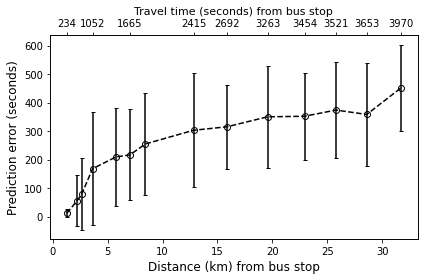

14 14
14 14
PearsonrCorrelationCoefficeintMean: 
0.9289620609194672
PearsonrCorrelationCoefficeintSTD: 
0.7119881075563027
PearsonrCorrelationCoefficeintMeanTActual: 
0.9303267279052778
PearsonrCorrelationCoefficeintSTDTActual: 
0.7155176551269204
(-0.2530742780170834, 33.24133377279121)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


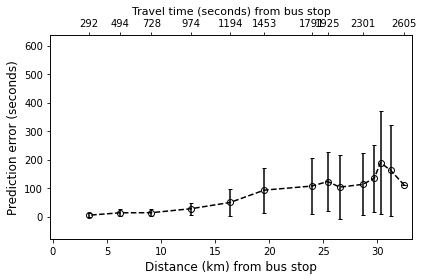

In [11]:
Extract_and_Plot_PredictionError_SouthBound(TripStartTimeAggregate, ResultPathDir, NpPathDir, ResultPathDir_Np, UseMongoDB)
Extract_and_Plot_PredictionError_NorthBound(TripStartTimeAggregate, ResultPathDir, NpPathDir, ResultPathDir_Np, UseMongoDB)

# MongoDB Save/Load

In [12]:
def LoadInMongoFromNp(RouteName, NpPathDir):
    
    '''
    input: The route name and numpy directory path
    output: The MongoDB database collections from the Numpy files
    function: It creates the MongoDB database from the Numpy files.
    '''    
    
    CollectionNames = os.listdir(f'{NpPathDir}/{RouteName}')
    #print(CollectionNames)
    
    CollectionNames_1 = [rec for rec in CollectionNames if '\'.' not in rec] # To address the error
    
    #print('Saving data in mongoDB')
    for Collection in CollectionNames_1:
        RecordsList = np.load(f'{NpPathDir}/{RouteName}/{Collection}', allow_pickle=True)
        #print(Collection)
        #pprint.pprint(RecordsList[0:3])
        
        CollectionName = Collection[0:-4]
        
        print(RouteName, CollectionName)
        con[RouteName][CollectionName].insert_many(RecordsList.tolist())
        
    
    
def SaveInNp(RouteName, NpPathDir):
    
    '''
    input: The route name and numpy directory path
    output: Numpy files of the MongoDB database
    function: It stores the Numpy files for the MongoDB database in the specified directory path
    '''
        
    
    CollectionNames = [Collection for Collection in 
                        con[RouteName].list_collection_names() if Collection!='system.indexes']

    CollectionNames_1 = [Collection for Collection in 
                         con[RouteName].list_collection_names() if 'Prediction' not in  Collection]
    
    for CollectionName in CollectionNames_1:
        print('CollectionName', CollectionName)
        RecordsList = [rec for rec in con[RouteName][CollectionName].find().sort([('_id',1)])]

        for RecordDict in RecordsList:
            del[RecordDict['_id']]

        if os.path.exists(os.path.join(NpPathDir, RouteName)) == False:
            os.mkdir(os.path.join(NpPathDir, RouteName))

            
        #np.save(f'{Path}/{Database}/{CollectionName}.npy', RecordsList)
        np.save(os.path.join(NpPathDir, RouteName,f'{CollectionName}.npy'), RecordsList)
    
    print('Unsaved collection')
    print([Collection for Collection in 
           con[RouteName].list_collection_names() if 'Prediction' in  Collection])
    

In [13]:
if UsedPreTrained == False:
    SaveInNp(RouteName, NpPathDir)
    
elif UseMongoDB==True:
    
    RouteNamesList = con.list_database_names()
    if RouteName not in RouteNamesList:
        '''Load the data for RouteName, if RouteName is not in RouteNamesList'''
        print('Loading MongoData from Np files')
        LoadInMongoFromNp(RouteName, NpPathDir)

CollectionName 14_02_2018__18_30_22.BusStopsRecord
CollectionName 02_02_2018__07_38_50.Filtered
CollectionName H.18.South.21_02_2018__18_28_29
CollectionName 20_03_2018__07_28_45.Filtered
CollectionName 03_04_2018__07_38_31.RawRecords
CollectionName TripStartTimeAggregate
CollectionName H.07.North.08_01_2018__07_41_43
CollectionName 19_02_2018__07_46_19.RawRecords
CollectionName 14_02_2018__07_41_04.Filtered
CollectionName H.18.South.20_02_2018__18_31_07
CollectionName 01_02_2018__07_39_12.RawRecords
CollectionName 30_01_2018__07_42_30.BusStopsRecord
CollectionName 15_02_2018__16_08_22.RawRecords
CollectionName H.18.South.22_12_2017__07_38_21
CollectionName 20_02_2018__18_31_07.Filtered
CollectionName 21_02_2018__07_42_42.BusStopsRecord
CollectionName 21_02_2018__07_42_42.RawRecords
CollectionName H.07.North.28_03_2018__18_30_02
CollectionName 13_03_2018__07_29_52.RawRecords
CollectionName H.07.North.21_02_2018__18_28_29
CollectionName 14_03_2018__07_35_46.Filtered
CollectionName 18_01